In [1]:
#Import required libraries
import os
import argparse
import networkx as nx
import math        
import numpy as np
import helper
import astar
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import csv
from random import randint, random, seed, uniform
import time

# (restrict tensorflow memory growth)
tf.disable_v2_behavior()
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
# learning rate
lr = 1e-4

# problem dimensions
dim = 2
dataElements = dim*3 + 2500 # sample (2D), init(2D), goal(2D), occup_grid(100) 

z_dim = 4 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# define networks
print("X_dim = ",X_dim)
print("c_dim = ",c_dim)
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])
    
# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

w = [[1, 1]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)

kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

X_dim =  2
c_dim =  2504
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
saver = tf.train.Saver()
path_ = os.getcwd() + "/../Models/checkpoints_NS_50x50/model.ckpt"
print("path = ",path_)
try:
    saver.restore(sess, path_)
    print("Model Restored!!")
except Exception as e:
    print("Could not restore checkpoint!")
    print(e)

path =  /home/kushal/Downloads/CS-RRT/LEGO/../Models/checkpoints_NS_50x50/model.ckpt
INFO:tensorflow:Restoring parameters from /home/kushal/Downloads/CS-RRT/LEGO/../Models/checkpoints_NS_50x50/model.ckpt
Model Restored!!


In [4]:
class LEGO:

    def __init__(self, start, goal, occ_grid,
                 path_resolution=0.005,
                 max_samples=1000,
                 graph_file="../Sparse_Graph/sparse_graph.graphml"):
        
        self.start = np.array([start[0], start[1]])
        self.goal = np.array([goal[0], goal[1]])
        self.occ_grid = occ_grid   
        self.path_resolution = path_resolution
        self.max_samples = max_samples
        self.uniformG = nx.read_graphml(graph_file)
        self.dim = self.occ_grid.shape[0]

        self.G = nx.Graph()  
        self.node_id = 0
        self.nodes_to_index = dict()
    
    def planning(self):
        num_samples = 0
        
        while(num_samples < self.max_samples):
            num_viz = 100
            num_samples += num_viz
            c_sample_seed = np.concatenate((self.start, self.goal, self.occ_grid.reshape(2500)))
            c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
            b_nodes, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})
            
            new_nodes_ind = self.uniformG.number_of_nodes()
            if num_samples == num_viz:
                self.uniformG.add_node(str(self.uniformG.number_of_nodes()),state = helper.numpy_to_state(self.start))
                self.uniformG.add_node(str(self.uniformG.number_of_nodes()),state = helper.numpy_to_state(self.goal))
                
            for node in b_nodes:
                if helper.is_point_free(node, self.occ_grid):
                    self.uniformG.add_node(str(self.uniformG.number_of_nodes()),state = helper.numpy_to_state(node))

            for i in range(new_nodes_ind, self.uniformG.number_of_nodes()):
                    i_str = str(i)
                    for j in self.uniformG.nodes():
                        if i_str!=j:
                            s = helper.state_to_numpy(self.uniformG.nodes[i_str]['state'])
                            t = helper.state_to_numpy(self.uniformG.nodes[j]['state'])
                            if self.calc_dist(s,t) < 0.08:
                                    self.uniformG.add_edge(i_str, j)
                                    self.uniformG[i_str][j]['weight'] = self.calc_dist(s, t)

            path, dis = astar.astar1(self.uniformG, str(200), str(201), self.occ_grid, inc = 0, h_weight=1)
            end_time = time.time()
        
            if dis != None:
                return path, dis, end_time
    
        return None, None, end_time

    def draw_graph(self, graph, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "../dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1.0/self.dim,          # width
                    1.0/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
        
        if rnd is not None:
            plt.scatter(rnd[0], rnd[1], color = "black", s = 30)
        
        for index in graph:
            s = helper.state_to_numpy(graph.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "green", s = 30)
            
        for (u,v,d) in graph.edges(data='weight'):
            u_state = helper.state_to_numpy(graph.nodes[u]['state'])
            v_state = helper.state_to_numpy(graph.nodes[v]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-y")

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black")

        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black")
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)
        
    def draw_nodes(self, graph, nearest_node,rnd_node):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "../dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(50):
            for j in range(50):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/50.0,j/50.0),   # (x,y)
                    0.02,          # width
                    0.02,          # height
                    alpha=0.6,
                    color = "blue"
                    ))
        
        plt.scatter(rnd_node[0], rnd_node[1], color = "black", s = 100)
        plt.scatter(nearest_node[0], nearest_node[1], color = "red", s = 100)
        
        for index in graph:
            s = helper.state_to_numpy(graph.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "green", s = 30)
            
        for (u,v,d) in graph.edges(data='weight'):
            u_state = helper.state_to_numpy(graph.nodes[u]['state'])
            v_state = helper.state_to_numpy(graph.nodes[v]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-y")

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black",alpha = 0.5)

        plt.scatter(self.start[0], self.start[1], color = "blue",  s = 50, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 50, edgecolors="black")
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
#         print(node_list)
        dlist = [(node[0] - rnd_node[0]) ** 2 + (node[1] - rnd_node[1])
                 ** 2 for node in node_list]
        minind = dlist.index(min(dlist))
        return minind

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node[0] - from_node[0]
        dy = to_node[1] - from_node[1]
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta
    
    @staticmethod
    def calc_dist(from_node, to_node):
        return np.linalg.norm(to_node-from_node) 
        
    def draw_lego_samples(self, b_nodes):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1/self.dim,          # width
                    1/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
            
        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black")
        plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01) 
        
    
    def draw_path(self, path):
        self.G = self.uniformG
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1/self.dim,          # width
                    1/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
        
        for index in range(self.uniformG.number_of_nodes()):
            s = helper.state_to_numpy(self.uniformG.nodes[str(index)]['state'])
            plt.scatter(s[0], s[1], color = "green", s = 30)
            
        for index in range(len(path)-1):
            u_state = helper.state_to_numpy(self.uniformG.nodes[path[index]]['state'])
            v_state = helper.state_to_numpy(self.uniformG.nodes[path[index+1]]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-r")
            
        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black")
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)

In [5]:
#Load Examples
start_pos = np.loadtxt("../Examples/start_pos.txt")
goal_pos = np.loadtxt("../Examples/goal_pos.txt")
occ_grids = np.loadtxt("../Examples/occ_grid.txt")

In [12]:
def decrease_resolution(occ_grid):
    new_occ_grid = np.empty([10, 10],dtype=int)
    dim = occ_grid.shape[0]
    scale = int(dim/10)
#     print(scale)
    i = 0
    j = 0
    while i < dim:
        j=0
        while j< dim:
            flag=0
            for m in range(scale):
                for n in range(scale):
                    if occ_grid[i+m][j+n] == 1: #is free
                        flag = 1
            if flag == 1:
                new_occ_grid[int(i/scale)][int(j/scale)]=1
            else:
                new_occ_grid[int(i/scale)][int(j/scale)]=0
#             print("index:",int(i/5),int(j/5)," Val:",new_occ_grid[int(i/5)][int(j/5)])
            j+=scale
        i+=scale
    return new_occ_grid

In [13]:
#choose example from test_example
i = randint(0,10)
occ_g = occ_grids[i]
occ_g_50 = occ_g.reshape(50,50)
new_occ_g = decrease_resolution(occ_g_50)
start = start_pos[i]
goal = goal_pos[i]

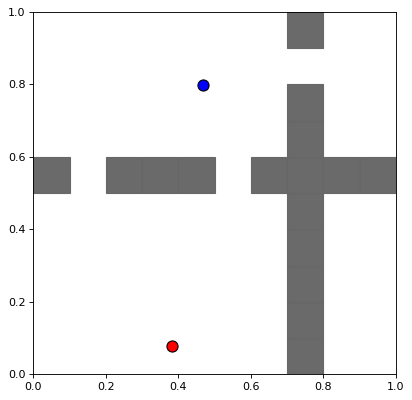

In [14]:
#Show the 10x10 figure formed after application of kernel
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(10):
        for j in range(10):
            if(new_occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=6,
                color = "#676767"
                ))

plt.scatter(start[0], start[1], color = "red",  s = 100, edgecolors="black")
plt.scatter(goal[0], goal[1], color = "blue",  s = 100, edgecolors="black")
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

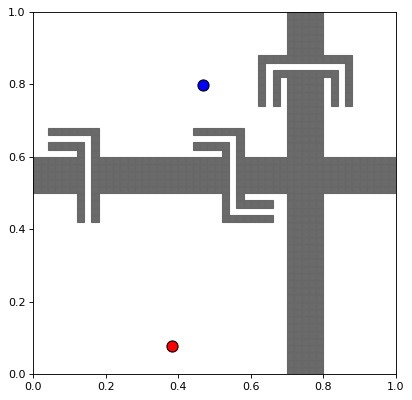

In [15]:
#Show the 50x50 figure 
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(50):
        for j in range(50):
            if(occ_g_50[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/50.0, j/50.0),   # (x,y)
                1/50.0,          # width
                1/50.0,          # height
                alpha=6,
                color = "#676767"
                ))

plt.scatter(start[0], start[1], color = "red",  s = 100, edgecolors="black")
plt.scatter(goal[0], goal[1], color = "blue",  s = 100, edgecolors="black")
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

Cannot find path


<Figure size 432x288 with 0 Axes>

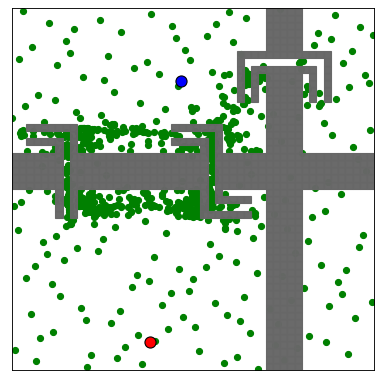

In [16]:
#Run LEGO-CVAE
planner = LEGO(start, goal, occ_g_50, max_samples = 1000)
start_time = time.time()
path, dis, end_time = planner.planning()
if dis is None:
    print("Cannot find path")
    planner.draw_path([])
else:
    print("found path!!")
    planner.draw_path(path)